In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import re
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as gensim_downloader
import os
nltk.download('stopwords')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_1411/2979231595.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
[nltk_data] Downloading package stopwords to /home/yao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Introduction
In times of crisis, people will often turn to social media to ask for help, but its often difficult to distinguish these pleas from more general posts algorithmically.  This notebook will attempt to classify posts using a variety of recurrent neural networks built towards text classification.  

The training data is roughly 7,000 posts of varying lengths with a maximum of ~160 characters.

As the final result is binary (0 for not a disaster post, 1 for a disaster post), I will use a sigmoidal neuron with binary cross entropy loss for the actual classification.

In [3]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import re
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader as gensim_downloader
import os
nltk.download('stopwords')

kaggle_path = '/kaggle/input'
local_path = './data'
if os.path.exists(kaggle_path):
    filepath = f"{kaggle_path}/nlp-getting-started"
else:
    filepath = local_path
    
train_df = pd.read_csv(f"{filepath}/train.csv")
test_df = pd.read_csv(f"{filepath}/test.csv")
print(f"The training data shape is: {train_df.shape}")
train_df.head()

The training data shape is: (7613, 5)


[nltk_data] Downloading package stopwords to /home/yao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


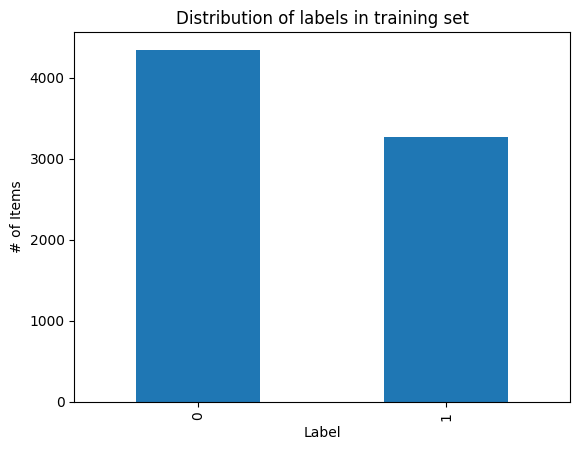

In [4]:
# Visualize the balance of labels...
label_counts = train_df['target'].value_counts()
label_counts.plot(kind="bar")
plt.title("Distribution of labels in training set")
plt.xlabel("Label")
plt.ylabel("# of Items")
plt.show()


## Visualizing the keyword feature
While there are a number of missing values, the keyword feature looks pretty robust with a number of unique values.  I'll keep this in the final training dataframe for now.

There are 221 unique keywords in the dataset
There are 61 missing keyword values


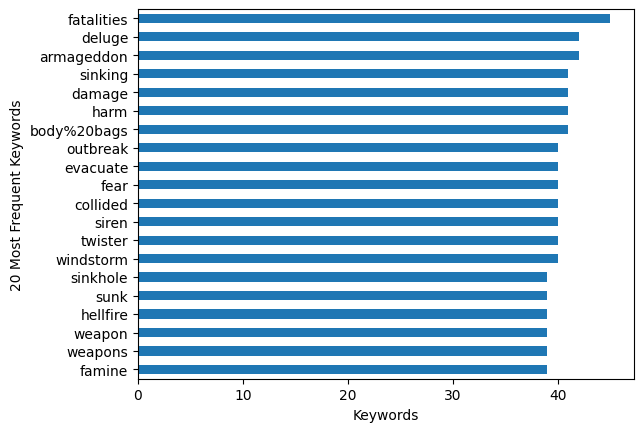

In [5]:
# Visualize the distribution of keywords
keyword_counts = train_df['keyword'].value_counts()
print(f"There are {len(keyword_counts)} unique keywords in the dataset")
print(f"There are {train_df['keyword'].isna().sum()} missing keyword values")
keyword_counts.nlargest(20).iloc[::-1].plot(kind="barh")
plt.xlabel("Keywords")
plt.ylabel("20 Most Frequent Keywords")
plt.show()

## Visualizing the location feature
Looking at the data, we might be better off omitting this data before training given the large amount of both unique values as well as missing values.

There are 3341 unique locations in the dataset
There are 2533 missing locations values


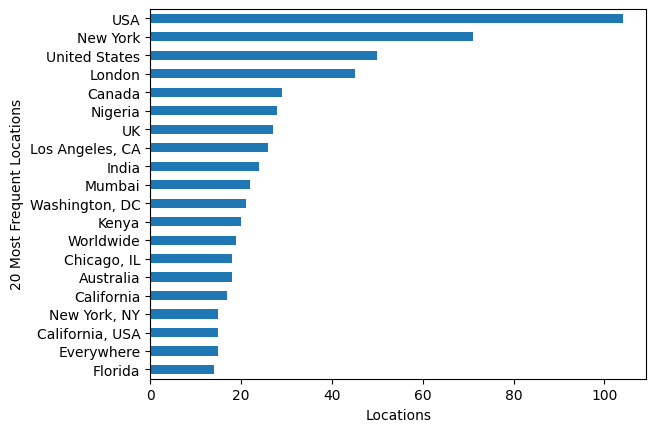

In [6]:
# Visualize the distribution of locations
location_counts = train_df['location'].value_counts(ascending=True)
print(f"There are {len(location_counts)} unique locations in the dataset")
print(f"There are {train_df['location'].isna().sum()} missing locations values")
location_counts.nlargest(20).iloc[::-1].plot(kind="barh")
plt.xlabel("Locations")
plt.ylabel("20 Most Frequent Locations")
plt.show()

## Analysis of the text itself
No missing or empty records, but there are a number of short posts (less than 20 characters).  Thankfully, a majority of posts look to be at least 40 characters.  We also have a normal-ish distribution over the number of words in the various posts.

Looking into the shorter posts, it looks like I can safely remove posts with one word or less than 10 characters without removing any positively labelled data

There are 0 missing/empty text values


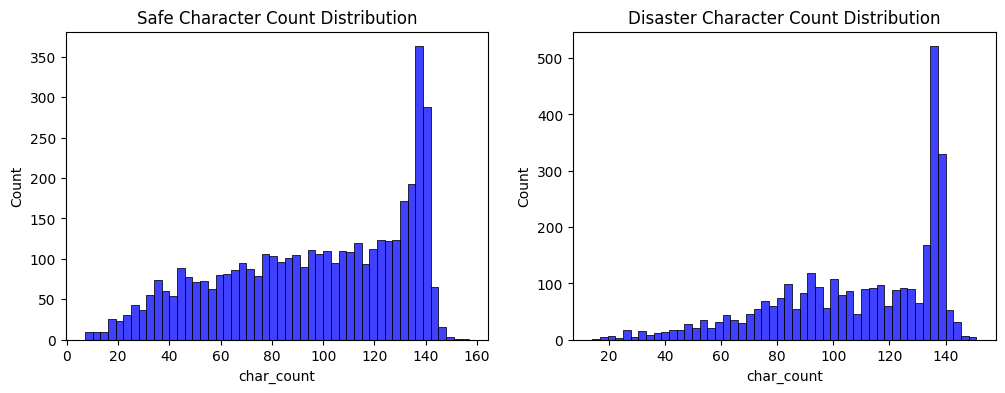

In [7]:
print(f"There are {train_df['text'].isna().sum()} missing/empty text values")
train_df['char_count'] = train_df['text'].apply(len)
train_df['word_count'] = train_df['text'].apply(lambda str: len(str.split()))
char_count = train_df['char_count'].value_counts()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(train_df[train_df['target'] == 0]['char_count'], bins=50, color='blue')
plt.title('Safe Character Count Distribution')

plt.subplot(1, 2, 2)
sns.histplot(train_df[train_df['target'] == 1]['char_count'], bins=50, color='blue')
plt.title('Disaster Character Count Distribution')
plt.show()

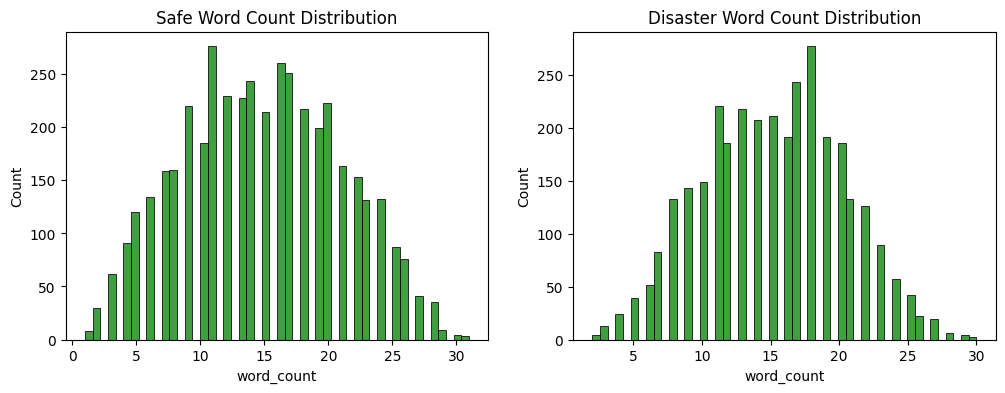

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(train_df[train_df['target'] == 0]['word_count'], bins=50, color='green')
plt.title('Safe Word Count Distribution')

plt.subplot(1, 2, 2)
sns.histplot(train_df[train_df['target'] == 1]['word_count'], bins=50, color='green')
plt.title('Disaster Word Count Distribution')
plt.show()

In [9]:
# Take a look at the shorter posts... 
train_df[train_df['char_count'] <= 10]
# train_df['char_count'].nsmallest(20)

,id,keyword,location,text,target,char_count,word_count
24,36,NaN,NaN,LOOOOOOL,0,8,1
28,40,NaN,NaN,Cooool :),0,9,2
30,44,NaN,NaN,The end!,0,8,2
1882,2703,crushed,NaN,Crushed,0,7,1
3667,5221,fatality,Nairobi,Fatality!,0,9,1
3670,5224,fatality,Rafael castillo,fatality,0,8,1
3749,5326,fire,NaN,I See Fire,0,10,3
4890,6962,massacre,NaN,Bad day,0,7,2
4971,7088,meltdown,NaN,Meltdown,0,8,1
5115,7295,nuclear%20reactor,NaN,Err:509,0,7,1


In [ ]:
# And the posts with few words.  Lost of overlap, but not necessarily the same
train_df[train_df['word_count'] < 2]


,id,keyword,location,text,target,char_count,word_count
24,36,NaN,NaN,LOOOOOOL,0,8,1
1882,2703,crushed,NaN,Crushed,0,7,1
3667,5221,fatality,Nairobi,Fatality!,0,9,1
3670,5224,fatality,Rafael castillo,fatality,0,8,1
4971,7088,meltdown,NaN,Meltdown,0,8,1
5115,7295,nuclear%20reactor,NaN,Err:509,0,7,1
5184,7400,obliterated,New York,Obliterated,0,11,1
6705,9605,thunder,NaN,Thunder???,0,10,1


In [11]:
duplicated_texts = train_df[train_df.duplicated(['text'], keep=False)]
duplicated_texts.head()

,id,keyword,location,text,target,char_count,word_count
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,114,8
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0,114,8
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,138,16
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0,138,16
118,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0,138,16


In [12]:
# Tokenize and count words
all_words = ' '.join(train_df['text']).split()
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word.lower() not in stop_words]
word_counts = Counter(filtered_words)

print(word_counts.most_common(20))

[('-', 763), ('like', 318), ('&amp;', 295), ('??', 214), ('via', 208), ('get', 183), ('fire', 148), ('...', 147), ('people', 146), ('2', 145), ('|', 142), ('one', 142), ('would', 116), ('new', 105), ('got', 103), ('New', 98), ('????', 96), ('know', 96), ('video', 93), ('going', 91)]


In [13]:
# Top 10 bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))  # Change to (1, 1) for unigrams, (3, 3) for trigrams
ngrams = vectorizer.fit_transform(train_df['text'])
ngram_counts = zip(vectorizer.get_feature_names_out(), ngrams.sum(axis=0).tolist()[0])
sorted_ngrams = sorted(ngram_counts, key=lambda x: x[1], reverse=True)

print(sorted_ngrams[:10])

[('http co', 4306), ('https co', 410), ('in the', 308), ('of the', 256), ('û_ http', 217), ('on the', 129), ('to the', 126), ('to be', 108), ('for the', 97), ('at the', 85)]


In [14]:
# Trigram analysis
vectorizer = CountVectorizer(ngram_range=(3,3))  # Change to (1, 1) for unigrams, (3, 3) for trigrams
ngrams = vectorizer.fit_transform(train_df['text'])
ngram_counts = zip(vectorizer.get_feature_names_out(), ngrams.sum(axis=0).tolist()[0])
sorted_ngrams = sorted(ngram_counts, key=lambda x: x[1], reverse=True)

print(sorted_ngrams[:10])

[('û_ http co', 217), ('liked youtube video', 42), ('video http co', 42), ('û_ https co', 35), ('homes razed by', 29), ('more homes razed', 29), ('northern california wildfire', 29), ('2015 http co', 28), ('bomber who detonated', 28), ('detonated bomb in', 28)]


In [15]:
# Given there's such a high occurence of http within the posts, I wanted to take a peek if there were any patterns....
http_records = train_df[train_df['text'].str.contains("http")]
print(f"{len(http_records)} records which contain http")
train_df[train_df['text'].str.contains("http")]

3971 records which contain http


,id,keyword,location,text,target,char_count,word_count
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55,5
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67,10
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82,9
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76,13
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,55,8
...,...,...,...,...,...,...,...
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,121,20
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1,134,16
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,11
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,8


## Text Cleaning
In order to clean, normalize, and shrink the final vocabulary size, I will preprocess the text using a series of modifications including lowercasing all the text, removing punctuation, etc.  In more robust models, we could largely forgo many of these steps as they are essentially removing information for the sake of computational efficiency.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

class TweetPreprocessor:
    def __init__(self, max_length=50):
        self.stop_words = set(stopwords.words('english'))
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.max_length = max_length
        self.vocab_size = 2  # Starting with PAD and UNK tokens
        
    def clean_text(self, text):
        """Clean and tokenize a single tweet"""
        # Lowercase and basic cleaning
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
        text = re.sub(r'@\w+', '', text)  # Remove mentions
        text = re.sub(r'#(\w+)', r'\1', text)  # Keep hashtag content without #
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        tokens = [word for word in tokens if word not in self.stop_words]
        # If empty, pad it to prevent empty results
        if len(tokens) == 0:
            tokens = ["<UNK>"]  # Add a placeholder token if the sequence is empty
            # print('found empty')
        
        return tokens
    
    def build_vocab(self, texts, min_freq=2):
        """Build vocabulary from corpus"""
        word_counts = {}
        
        # Count word frequencies
        for text in texts:
            tokens = self.clean_text(text)
            for token in tokens:
                word_counts[token] = word_counts.get(token, 0) + 1
        
        # Add words that meet minimum frequency
        for word, count in word_counts.items():
            if count >= min_freq:
                self.word2idx[word] = self.vocab_size
                self.idx2word[self.vocab_size] = word
                self.vocab_size += 1
                
        print(f"Vocabulary size: {self.vocab_size}")
    
            
    def text_to_indices(self, text):
        tokens = self.clean_text(text)
        return [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokens]

    
    def encode_text(self, text):
        """Converts text to sequence of encoded indices with padding"""
        tokens = self.clean_text(text)
        # Truncate or pad sequence to max_length
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        
        # Convert tokens to indices
        indices = [self.word2idx.get(token, self.word2idx["<UNK>"]) for token in tokens]
        
        # Pad the sequence
        padded = indices + [self.word2idx["<PAD>"]] * (self.max_length - len(indices))
        
        return padded



class Word2VecEmbedder:
    def __init__(self, preprocessor, embedding_dim=300):
        self.preprocessor = preprocessor
        self.embedding_dim = embedding_dim
        self.model = None
        
    def train_embeddings(self, texts, window=5, min_count=1, workers=4):
        sentences = [self.preprocessor.clean_text(text) for text in texts]
        
        # Train Word2Vec model
        self.model = Word2Vec(sentences, 
                             vector_size=self.embedding_dim,
                             window=window,
                             min_count=min_count,
                             workers=workers)
        
        print(f"Trained Word2Vec model with {len(self.model.wv)} words")
        
    def create_embedding_matrix(self):
        """Create embedding matrix for vocabulary"""
        if self.model is None:
            raise ValueError("Word2Vec model not trained yet")
            
        embedding_matrix = np.zeros((self.preprocessor.vocab_size, self.embedding_dim))
        
        # Fill embedding matrix
        for word, idx in self.preprocessor.word2idx.items():
            if word in self.model.wv:
                embedding_matrix[idx] = self.model.wv[word]
                
        return embedding_matrix

class EmbeddingLoader:
    def __init__(self, embedding_type='word2vec'):
        self.embedding_type = embedding_type
        self.embedding_model = None
        self.embedding_dim = None
        
    def load_embeddings(self, embedding_type=None, custom_path=None):
        """
        Loads pre-trained embeddings
        
        Args:
            embedding_type: 'word2vec', 'glove', 'fasttext', or 'custom'
            custom_path: Path to custom embedding file (if embedding_type='custom')
        """
        if embedding_type:
            self.embedding_type = embedding_type
            
        if self.embedding_type == 'word2vec':
            # Load Google's pre-trained Word2Vec model
            print("Loading Word2Vec embeddings...")
            self.embedding_model = gensim_downloader.load('word2vec-google-news-300')
            self.embedding_dim = 300
            
        elif self.embedding_type == 'glove':
            # Load GloVe embeddings (Twitter)
            print("Loading GloVe Twitter embeddings...")
            self.embedding_dim = 25  # Change based on which glove model you load
            self.embedding_model = gensim_downloader.load(f'glove-twitter-{self.embedding_dim}')  # Options: 25, 50, 100, 200
            
        elif self.embedding_type == 'fasttext':
            # Load FastText embeddings
            print("Loading FastText embeddings...")
            self.embedding_model = gensim_downloader.load('fasttext-wiki-news-subwords-300')
            self.embedding_dim = 300
            
        elif self.embedding_type == 'custom' and custom_path:
            # Load custom embeddings from file
            print(f"Loading custom embeddings from {custom_path}...")
            self.embedding_model = KeyedVectors.load_word2vec_format(custom_path)
            self.embedding_dim = self.embedding_model.vector_size
            
        else:
            raise ValueError("Invalid embedding type or missing custom path")
            
        print(f"Loaded {self.embedding_type} embeddings with dimension {self.embedding_dim}")
        return self.embedding_model, self.embedding_dim
    
    def create_embedding_matrix(self, word2idx):
        """
        Create an embedding matrix for the given vocabulary
        
        Args:
            word2idx: Dictionary mapping words to indices
            
        Returns:
            embedding_matrix: numpy array of shape (vocab_size, embedding_dim)
        """
        vocab_size = len(word2idx)
        embedding_matrix = np.zeros((vocab_size, self.embedding_dim))
        
        for word, idx in word2idx.items():
            try:
                embedding_matrix[idx] = self.embedding_model[word]
            except (KeyError, TypeError):
                # If word not in embeddings, leave as zeros (can be learned during training)
                continue
                
        return embedding_matrix

[nltk_data] Downloading package punkt to /home/yao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## On embeddings
There are a variety of ways to approach text embedding including using something like sklearn's count and td-idf vectorizers, which use word frequency and a text length normalized word frequency approach respectively, training a custom embedding model with word2vec, using pretrained embeddings like Word2vec's google news embeddings or GloVe's twitter based embeddings.  

For the sake of brevity, I'm primarily testing custom word2vec embeddings trained on this training dataset and the GloVe 25 embeddings.

I'm omitting discussion of transformer based embeddings as they are out of scope for this class exercise.

In [ ]:
# Initialize preprocessor
max_text_length = 399
preprocessor = TweetPreprocessor(max_length=max_text_length)

# # Build vocabulary from training data
preprocessor.build_vocab(train_df['text'])

# # Train a custom embedding model
# embedder = Word2VecEmbedder(preprocessor, embedding_dim=max_text_length)
# embedder.train_embeddings(train_df['text'])
# embedding_dim=max_text_length

# embedding_matrix = embedder.create_embedding_matrix()

# Load pretrained embeddings and map out vocab to it
embedding_loader = EmbeddingLoader(embedding_type='glove')
embedding_model, embedding_dim = embedding_loader.load_embeddings()

# Create embedding matrix for vocabulary
embedding_matrix = embedding_loader.create_embedding_matrix(preprocessor.word2idx)

Vocabulary size: 6453
Loading GloVe Twitter embeddings...
Loaded glove embeddings with dimension 25


In [146]:
class TextDataset(Dataset):
    def __init__(self, dataframe, preprocessor, embedding_matrix=embedding_matrix):
        self.texts = [preprocessor.text_to_indices(text) for text in dataframe['text']]
        self.labels = dataframe['target'].values
        self.preprocessor = preprocessor
        self.embeddings = embedding_matrix
        self.lengths = [len(text) for text in self.texts]  # Store sequence lengths
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        text_indices = self.texts[idx]
        length = self.lengths[idx]  # Include sequence length
        return torch.tensor(text_indices, dtype=torch.long), torch.tensor(label, dtype=torch.float), torch.tensor(length, dtype=torch.long)


In [147]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

def collate_fn(batch):
    texts, labels, lengths = zip(*batch)
    
    # Pad sequences
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    
    # Sort by length for pack_padded_sequence
    lengths = torch.tensor(lengths)
    sorted_idx = torch.argsort(lengths, descending=True)
    
    return padded_texts[sorted_idx], torch.tensor(labels)[sorted_idx], lengths[sorted_idx]

def inference_collate_fn(batch):
    texts, lengths, ids = zip(*batch)
    
    # Pad sequences
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    
    # Convert lengths to a tensor
    lengths = torch.tensor(lengths)
    ids = torch.tensor(ids)
    # Sort by length for pack_padded_sequence (optional, but recommended for efficiency)
    sorted_idx = torch.argsort(lengths, descending=True)
    
    return padded_texts[sorted_idx], lengths[sorted_idx], ids[sorted_idx]

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0, bidirectional=False, embedding_matrix=embedding_matrix):
        super(LSTMModel, self).__init__()
        
        # Embedding layer with optional pre-trained weights
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        if embedding_matrix is not None:
            self.embeddings.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers, 
            bidirectional=bidirectional, 
            dropout=dropout if num_layers > 1 else 0, 
            batch_first=True
        )
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(lstm_output_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, text_lengths):
        # x shape = (batch size, sequence length)
        embedded = self.dropout(self.embeddings(x))  # shape = (batch size, sequence length, embedding dim)
        
        # Pack the sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # We could use this output in the final prediction, but just using the hidden state 
        #   as the model is small enough to avoid the computational overhead
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
        
        # For bidirectional LSTM, concatenate the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
        # hidden shape = (batch size, hidden dim)
        final_output = self.fc(hidden)
        return torch.sigmoid(final_output)


In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0, bidirectional=False, embedding_matrix=embedding_matrix):
        super(RNNModel, self).__init__()
       
        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=True)
        # batch first should return tensor shape [batch, sequence, feature]
        self.rnn = nn.RNN(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
       
        # We are moving from hidden layer to a single, fully connected layer for binary output
        output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(output_dim, 1)
       
        self.output = nn.Sigmoid() # Our final output is evaluated against binary cross entropy, so we need sigmoidal output...
        self.dropout = nn.Dropout(dropout)
       
       
    def forward(self, x, text_lengths):
        # X shape = (batch_size, sequence)
        x = self.dropout(self.embeddings(x))  # shape = (batch size, sequence length, embedding dim)

        # Make sure text_lengths is on CPU
        packed_embedded = pack_padded_sequence(x, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
       
        # The RNN function only takes the packed input, no need for text_lengths here
        packed_output, hidden = self.rnn(packed_embedded)
        
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
       
        # Get the last output of the sequence...:
        batch_size = output.size(0)
        hidden_dim = output.size(2)
        
        last_outputs = torch.zeros(batch_size, hidden_dim, device=output.device)
        
        # as the inputs are variable length, the outputs are as well, so we need to get the last value
        #   individually for each sample
        for i, length in enumerate(output_lengths):
            last_outputs[i] = output[i, length-1]

        fc_output = self.fc(last_outputs)
        final_output = self.output(fc_output)
        return final_output

In [164]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class GRUModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0, bidirectional=False, embedding_matrix=embedding_matrix):
        super(GRUModel, self).__init__()
       
        self.embeddings = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=True)
        # batch first should return tensor shape [batch, sequence, feature]
        self.gru = nn.GRU(
            embedding_dim, 
            hidden_dim, 
            num_layers=num_layers,
            batch_first=True, 
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        self.dropout = nn.Dropout(dropout)
       
       
        # We are moving from hidden layer to a single, fully connected layer for binary output
        output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(output_dim, 1)
       
        self.output = nn.Sigmoid() # Our final output is evaluated against binary cross entropy, so we need sigmoidal output...
       
    def forward(self, x, text_lengths):
        # X shape = (batch_size, sequence)
        # x = self.embeddings(x)  # x shape = (batch_size, sequence, embedding dim)
        x = self.dropout(self.embeddings(x))  # shape = (batch size, sequence length, embedding dim)
        
        # Make sure text_lengths is on CPU
        packed_embedded = pack_padded_sequence(x, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
       
        # The RNN function only takes the packed input, no need for text_lengths here
        packed_output, hidden = self.gru(packed_embedded)
        
        output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)
       
        # Get the last output of the sequence...:
        batch_size = output.size(0)
        hidden_dim = output.size(2)
        
        last_outputs = torch.zeros(batch_size, hidden_dim, device=output.device)
        
        for i, length in enumerate(output_lengths):
            last_outputs[i] = output[i, length-1]

        fc_output = self.fc(last_outputs)
        final_output = self.output(fc_output)
        return final_output

In [182]:
import time

# Training parameters
# embedding_dim = 300
vocab_size = preprocessor.vocab_size       
hidden_dim = 256
num_classes = 2  # binary class results
num_layers = 2
seed = 42
dropout = 0.5

# Model hyperparameters
learning_rate = 1e-2
num_epochs = 20
batch_size = 32

# Prep the training...
torch.manual_seed(seed)
start_time = time.time()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.BCELoss()

# Using stratification just to even up the distribution of positive/negative labels...
train_split, valid_split = train_test_split(train_df, test_size=0.2, random_state=seed,stratify=train_df['target'])

train_data = TextDataset(train_split, preprocessor)
valid_data = TextDataset(valid_split, preprocessor)

train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_size, shuffle=False, num_workers=4,collate_fn=collate_fn)

from sklearn.metrics import f1_score

def train(model):
    train_acc = []
    train_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        all_preds = []
        all_labels = []
        
        for texts, labels, lengths in train_loader:
            texts = texts.to(device)
            lengths = lengths.to(device)
            labels = labels.unsqueeze(1).to(device)
            
            optimizer.zero_grad()
            predictions = model(texts, lengths)
            
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * len(texts)
            preds = (predictions > 0.5).int()
            total_correct += (preds == labels).sum().item()
            total_samples += len(texts)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / total_samples
        accuracy = total_correct / total_samples
        f1 = f1_score(all_labels, all_preds)
        train_acc.append(accuracy)
        train_loss.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    return train_loss, train_acc

def validate(model):
    model.eval()
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        val_loss = 0
        for texts, labels, lengths in train_loader:
            texts = texts.to(device)
            lengths = lengths.to(lengths)
            labels = labels.unsqueeze(1).to(device)
            predictions = model(texts,lengths)
            val_loss += criterion(predictions, labels).item() * len(texts)  # Multiply by batch size
    
            # Calculate validation accuracy
            preds = (predictions > 0.5).int()  # Convert probabilities to binary predictions
            val_correct += (preds == labels).sum().item()  # Count correct predictions
            val_samples += len(texts)  # Count total samples
    
        # Calculate average validation loss and accuracy
        avg_val_loss = val_loss / val_samples
        val_accuracy = val_correct / val_samples
        print(f"Validation: Average loss: {avg_val_loss}, accuracy: {val_accuracy}")
    return val_accuracy



In [183]:
gru_model = GRUModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout=dropout).to(device)
gru_training_loss, gru_training_acc = train(gru_model)
gru_valid_acc = validate(gru_model)
# Validation: Average loss: 0.08158634138126875, accuracy: 0.9740558292282431

Epoch [1/20], Loss: 0.6031, Accuracy: 0.7008, F1: 0.6350
Epoch [2/20], Loss: 0.5426, Accuracy: 0.7383, F1: 0.6728
Epoch [3/20], Loss: 0.5349, Accuracy: 0.7432, F1: 0.6781
Epoch [4/20], Loss: 0.5319, Accuracy: 0.7468, F1: 0.6798
Epoch [5/20], Loss: 0.5263, Accuracy: 0.7435, F1: 0.6804
Epoch [6/20], Loss: 0.5272, Accuracy: 0.7478, F1: 0.6874
Epoch [7/20], Loss: 0.5237, Accuracy: 0.7544, F1: 0.6904
Epoch [8/20], Loss: 0.5322, Accuracy: 0.7483, F1: 0.6891
Epoch [9/20], Loss: 0.5304, Accuracy: 0.7435, F1: 0.6791
Epoch [10/20], Loss: 0.5442, Accuracy: 0.7406, F1: 0.6750
Epoch [11/20], Loss: 0.5481, Accuracy: 0.7332, F1: 0.6694
Epoch [12/20], Loss: 0.5395, Accuracy: 0.7379, F1: 0.6765
Epoch [13/20], Loss: 0.5357, Accuracy: 0.7404, F1: 0.6781
Epoch [14/20], Loss: 0.5431, Accuracy: 0.7320, F1: 0.6683
Epoch [15/20], Loss: 0.5503, Accuracy: 0.7378, F1: 0.6782
Epoch [16/20], Loss: 0.5562, Accuracy: 0.7291, F1: 0.6627
Epoch [17/20], Loss: 0.5415, Accuracy: 0.7371, F1: 0.6693
Epoch [18/20], Loss: 0.

In [184]:
rnn_model = RNNModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout=dropout).to(device)
rnn_training_loss, rnn_training_acc = train(rnn_model)
rnn_valid_acc = validate(rnn_model)

Epoch [1/20], Loss: 0.7278, Accuracy: 0.5353, F1: 0.3810
Epoch [2/20], Loss: 0.7033, Accuracy: 0.5360, F1: 0.3664
Epoch [3/20], Loss: 0.7133, Accuracy: 0.5261, F1: 0.4303
Epoch [4/20], Loss: 0.7218, Accuracy: 0.5534, F1: 0.3807
Epoch [5/20], Loss: 0.7138, Accuracy: 0.5452, F1: 0.3561
Epoch [6/20], Loss: 0.7017, Accuracy: 0.5524, F1: 0.3753
Epoch [7/20], Loss: 0.7143, Accuracy: 0.5589, F1: 0.4143
Epoch [8/20], Loss: 0.7019, Accuracy: 0.5581, F1: 0.4058
Epoch [9/20], Loss: 0.7129, Accuracy: 0.5429, F1: 0.3716
Epoch [10/20], Loss: 0.7275, Accuracy: 0.5365, F1: 0.4238
Epoch [11/20], Loss: 0.7122, Accuracy: 0.5529, F1: 0.4092
Epoch [12/20], Loss: 0.6900, Accuracy: 0.5545, F1: 0.3527
Epoch [13/20], Loss: 0.6969, Accuracy: 0.5757, F1: 0.4528
Epoch [14/20], Loss: 0.6808, Accuracy: 0.5865, F1: 0.4927
Epoch [15/20], Loss: 0.7332, Accuracy: 0.5585, F1: 0.4338
Epoch [16/20], Loss: 0.6833, Accuracy: 0.5903, F1: 0.4684
Epoch [17/20], Loss: 0.6862, Accuracy: 0.5892, F1: 0.4772
Epoch [18/20], Loss: 0.

In [185]:
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout=dropout).to(device)
lstm_training_loss, lstm_training_acc = train(lstm_model)
lstm_valid_acc = validate(lstm_model)
# Validation: Average loss: 0.04682021586328427, accuracy: 0.9807881773399014

Epoch [1/20], Loss: 0.5585, Accuracy: 0.7246, F1: 0.6523
Epoch [2/20], Loss: 0.4679, Accuracy: 0.8016, F1: 0.7529
Epoch [3/20], Loss: 0.4105, Accuracy: 0.8250, F1: 0.7822
Epoch [4/20], Loss: 0.3590, Accuracy: 0.8525, F1: 0.8188
Epoch [5/20], Loss: 0.3282, Accuracy: 0.8688, F1: 0.8411
Epoch [6/20], Loss: 0.3026, Accuracy: 0.8747, F1: 0.8471
Epoch [7/20], Loss: 0.2775, Accuracy: 0.8931, F1: 0.8716
Epoch [8/20], Loss: 0.2512, Accuracy: 0.9044, F1: 0.8853
Epoch [9/20], Loss: 0.2340, Accuracy: 0.9064, F1: 0.8879
Epoch [10/20], Loss: 0.2151, Accuracy: 0.9177, F1: 0.9017
Epoch [11/20], Loss: 0.2060, Accuracy: 0.9202, F1: 0.9046
Epoch [12/20], Loss: 0.1989, Accuracy: 0.9236, F1: 0.9089
Epoch [13/20], Loss: 0.1945, Accuracy: 0.9225, F1: 0.9076
Epoch [14/20], Loss: 0.1969, Accuracy: 0.9256, F1: 0.9117
Epoch [15/20], Loss: 0.1853, Accuracy: 0.9279, F1: 0.9141
Epoch [16/20], Loss: 0.1875, Accuracy: 0.9248, F1: 0.9106
Epoch [17/20], Loss: 0.1784, Accuracy: 0.9305, F1: 0.9177
Epoch [18/20], Loss: 0.

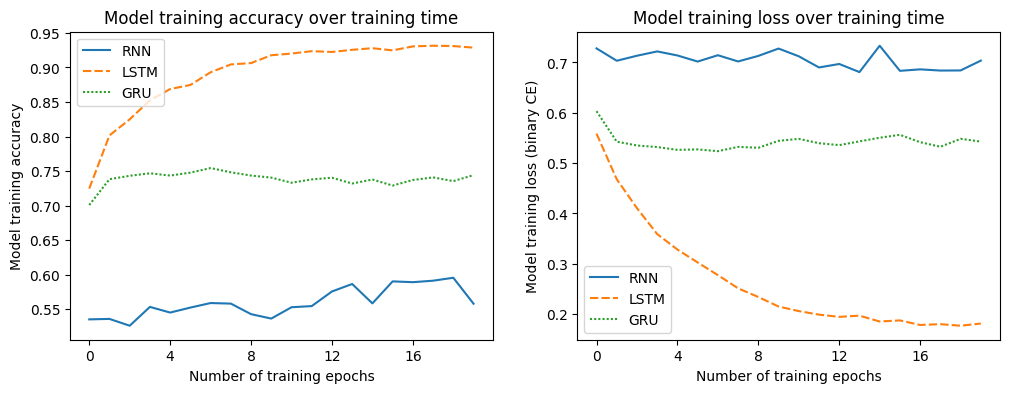

In [186]:
# Visualizing Acc + Loss across models...
model_acc = {
    'RNN': rnn_training_acc,
    'LSTM': lstm_training_acc,
    'GRU': gru_training_acc
}
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.lineplot(model_acc)
plt.title("Model training accuracy over training time")
plt.ylabel("Model training accuracy")
plt.xlabel("Number of training epochs")
plt.xticks(range(0,num_epochs,4))

model_loss = {
    'RNN': rnn_training_loss,
    'LSTM': lstm_training_loss,
    'GRU': gru_training_loss
}
plt.subplot(1, 2, 2)
sns.lineplot(model_loss)
plt.title("Model training loss over training time")
plt.ylabel("Model training loss (binary CE)")
plt.xlabel("Number of training epochs")

plt.xticks(range(0,num_epochs,4))
plt.show()

# Results + Analysis
We can see a strong outlier in the the LSTM performance over the GRU and RNN based architectures.  We can see that the LSTM converges around the 10th-12th epoch, but RNN and GRU based models converge quite early, if at all.  Moreover, while the GRU seems to be a 'happy medium' between the lstm and rnn architectures, the training speed efficiencies aren't enough to meaningfully choose the GRU architecture over an LSTM at this time.

## Learning rate + number of training epochs
Experimenting with learning rates between 1e-1 and 1e-4, 1e-2, performed the best overall in final test accuracy.  Using 20 epochs yielded the most performant models on the test dataset, as using more caused overfitting to the training data and less epochs led to an imprecise early stopping before any models could converge.

## Dropouts
Adding dropout layers in the initial input layer dramatically improved training performance across all models.  Using dropouts is a useful form of model regularization to avoid overfitting and train a more flexible model.  


## Embeddings
While the LSTM model performed decently under both conditions, all of the models performed markedly worse using custom trained Word2Vec embeddings vs pretrained GloVe embeddings.   As with most custom embeddings using this small of a data source (~6.5K vocab size, ~16k words) vs Glove-25 (400k vocab size, 6 billion words/tokens), the robustness of the custom embeddings is significantly diminished vs the larger pretrained embeddings.  

### Custom/trained embeddings vs pre-trained
While I originally wanted to use the google news trained Word2Vec embeddings, they were simply too large to use reliably with kaggle.  Instead, I chose the much smaller GloVe embeddings to reasonably good results.


# Conclusion

## LSTM
The clear winner in this test with a final 80% test accuracy with a 1e-2 learning rate, ADAM optimizer, and 50% dropout.  Using no dropout resulted in a much higher accuracy/F1-score on training and validation datasets, but the lstm model was likely overfitted as the test performance was lower than almost all other permutations.

## RNN
These models really performed poorly, between long training times to convergence (if it ever really did...), poor accuracy/F1 scores, and ultimately middling test accuracy, the lstm is the clear best choice so far. 

## GRU
Twas a close second to the LSTM, but only after mirroring the additional dropout layer within the model architecture.  Oddly enough, the actual training performance more closely matched the RNN, so its hard to determine exactly why the training performance was so low while the actual test performance was quite good at 79% accuracy. 

## Future Considerations
While each of these models could be bidirectionally tested and evaluated, the NLP community has largely abandoned these RNN based architectures in favor of transformer based architectures, so future endeavors would likely favor such an approach.

In [181]:
class TestDataset(Dataset):
    def __init__(self, dataframe, preprocessor, embedding_matrix=embedding_matrix):
        self.texts = [preprocessor.text_to_indices(text) for text in dataframe['text']]
        self.preprocessor = preprocessor
        self.embeddings = embedding_matrix
        self.lengths = [len(text) for text in self.texts]  # Store sequence lengths
        self.ids = dataframe['id']
        
        if any(length == 0 for id, length in enumerate(self.lengths)):
            raise ValueError(f"Found empty sequences in the dataset. Check the preprocessing steps.")
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text_indices = self.texts[idx]
        length = self.lengths[idx]  # Include sequence length
        return (
            torch.tensor(text_indices, dtype=torch.long), 
            torch.tensor(length, dtype=torch.long), 
            self.ids[idx]
        )

test_dataset = TestDataset(test_df,preprocessor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=inference_collate_fn)
model = lstm_model
# Generate predictions
predictions = []
ids = []
with torch.no_grad():  
    for texts,  lengths,input_ids in test_loader:
        texts = texts.to(device)
        lengths = lengths.to(device)
        outputs = model(texts,lengths)
        preds = (outputs > 0.5).int().squeeze()  # Convert probabilities to binary predictions
        
        predictions.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy array
        ids.extend(input_ids.cpu().numpy())  # Move IDs to CPU and convert to numpy array


# Create a submission DataFrame
submission_df = pd.DataFrame({
    'id': ids,
    'target': predictions
})

submission_filename = 'submission-lstm-32-GloVe-30-epochs-1e-3.csv'

# Save the submission file
submission_df.to_csv(submission_filename, index=False)
print(f"Submission file saved as '{submission_filename}'")
submission_df.head()

Submission file saved as 'submission-lstm-32-GloVe-30-epochs-1e-3.csv'


,id,target
0,150,0
1,90,1
2,101,0
3,127,0
4,72,0


# References
1. EDA techniques: https://www.kaggle.com/code/josephtk/disaster-tweets-classification-using-bert
2. Pytorch approach: https://www.youtube.com/watch?v=0_PgWWmauHk
3. RNN Overview: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
4. RNN Course: https://www.youtube.com/watch?v=6niqTuYFZLQ